In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp '/content/drive/My Drive/cifar-10-python (1).tar.gz' 'cfa.tar.gz'

!mkdir cifar

!tar -xf cfa.tar.gz --directory cifar


# Functions

In [ ]:
import numpy as np
import os
from keras import backend
import _pickle as cPickle
from google.colab.patches import cv2_imshow
from keras.utils.np_utils import to_categorical
from matplotlib import pyplot as plt
import tensorflow as tf
import keras

def unpickle(file):
    with open(file, 'rb') as fo:
        dict = cPickle.load(fo, encoding='bytes')
    return dict
def unpicklelabel():
    meta = unpickle('/content/cifar/cifar-10-batches-py/batches.meta')
    return meta[b'label_names']
def to_normal_image(img, grayscale=False, normalise=False):
  img1 = img.copy()
  img1.shape = (3,32,32)
  img1 = img1.transpose([1, 2, 0])
  if grayscale: img1 = np.mean(img1, axis =2)
  if normalise: img /= 255
  return img1


def load_batch(fpath, label_key='labels'):
  with open(fpath, 'rb') as f:
    d = cPickle.load(f, encoding='bytes')
    # decode utf8
    d_decoded = {}
    for k, v in d.items():
      d_decoded[k.decode('utf8')] = v
    d = d_decoded
  data = d['data']
  labels = d[label_key]

  data = data.reshape(data.shape[0], 3, 32, 32)
  return data, labels

def load_data():
  dirname = '/content/cifar/cifar-10-batches-py'

  num_train_samples = 50000

  x_train = np.empty((num_train_samples, 3, 32, 32), dtype='uint8')
  y_train = np.empty((num_train_samples,), dtype='uint8')

  for i in range(1, 6):
    fpath = os.path.join(dirname, 'data_batch_' + str(i))
    (x_train[(i - 1) * 10000:i * 10000, :, :, :],
     y_train[(i - 1) * 10000:i * 10000]) = load_batch(fpath)

  fpath = os.path.join(dirname, 'test_batch')
  x_test, y_test = load_batch(fpath)

  y_train = np.reshape(y_train, (len(y_train), 1))
  y_test = np.reshape(y_test, (len(y_test), 1))

  if backend.image_data_format() == 'channels_last':
    x_train = x_train.transpose(0, 2, 3, 1)
    x_test = x_test.transpose(0, 2, 3, 1)

  x_test = x_test.astype(x_train.dtype)
  y_test = y_test.astype(y_train.dtype)

  return (x_train, y_train), (x_test, y_test)

# Method one CNN

In [ ]:

import keras
import numpy as np
from tensorflow.keras import optimizers
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from keras.callbacks import LearningRateScheduler, TensorBoard
from keras.preprocessing.image import ImageDataGenerator

batch_size    = 128
epochs        = 50
iterations    = 391
num_classes   = 10
mean          = [125.307, 122.95, 113.865]
std           = [62.9932, 62.0887, 66.7048]

def build_model():
    model = Sequential()
    model.add(Conv2D(6, (5, 5), padding='valid', activation = 'relu', kernel_initializer='he_normal', input_shape=(32,32,3)))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(16, (5, 5), padding='valid', activation = 'relu', kernel_initializer='he_normal'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(120, activation = 'relu', kernel_initializer='he_normal'))
    model.add(Dense(84, activation = 'relu', kernel_initializer='he_normal'))
    model.add(Dense(10, activation = 'softmax', kernel_initializer='he_normal'))
    sgd = optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

def scheduler(epoch):
    if epoch < 100:
        return 0.01
    
    return 0.001


(x_train, y_train), (x_test, y_test) = load_data()
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')  


for i in range(3):
    x_train[:,:,:,i] = (x_train[:,:,:,i] - mean[i]) / std[i]
    x_test[:,:,:,i] = (x_test[:,:,:,i] - mean[i]) / std[i]
    

model = build_model()
print(model.summary())
# set callback
tb_cb = TensorBoard(log_dir='./lenet_dp_da', histogram_freq=0)
change_lr = LearningRateScheduler(scheduler)
cbks = [change_lr,tb_cb]

"""
print('Using real-time data augmentation.')
datagen = ImageDataGenerator(horizontal_flip=True,
        width_shift_range=0.125,height_shift_range=0.125,fill_mode='constant',cval=0.)

datagen.fit(x_train)

  
model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                    steps_per_epoch=iterations,
                    epochs=epochs,
                    callbacks=cbks,
                    validation_data=(x_test, y_test))
"""

history = model.fit(x_train,
          y_train,
          batch_size=batch_size,
                    steps_per_epoch=iterations,
                    epochs=epochs,
                    callbacks=cbks,
                    validation_data=(x_test, y_test))
    
scores = model.evaluate(x_train, y_train, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

KeyboardInterrupt: ignored

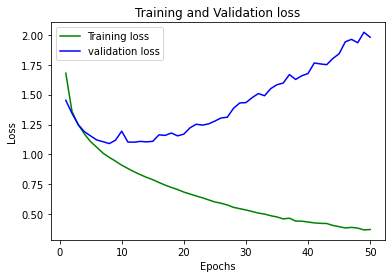

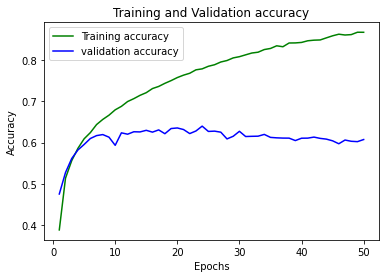

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
predictions = model.predict(x=x_test, steps=len(x_test), verbose=0)

# Method two

In [ ]:

import keras
import numpy as np
from tensorflow.keras import optimizers
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from keras.callbacks import LearningRateScheduler, TensorBoard
from keras.preprocessing.image import ImageDataGenerator


batch_size    = 128
epochs        = 50
iterations    = 391
num_classes   = 10
mean          = [125.307, 122.95, 113.865]
std           = [62.9932, 62.0887, 66.7048]


def scheduler(epoch):
    if epoch < 100:
        return 0.01
    
    return 0.001

"""
W_grid = 4
L_grid = 4

fig, axes = plt.subplots(L_grid, W_grid, figsize = (15, 15))
axes = axes.ravel()


for i in np.arange(0, L_grid * W_grid):
    index = np.random.randint(0, n_training) # pick a random number
    axes[i].imshow(X_train[index])
    axes[i].set_title(y_train[index])
    axes[i].axis('off')
    
plt.subplots_adjust(hspace = 0.4)
"""

#cnn.compile(optimizer = tf.keras.optimizers.RMSprop(0.0001, decay = 1e-6), loss ='categorical_crossentropy', metrics =['accuracy'])
epochs = 50



def build_model():
    model = Sequential()
    model.add(Conv2D(6, (5, 5), padding='valid', activation = 'relu', kernel_initializer='he_normal', input_shape=(32,32,3)))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(Conv2D(16, (5, 5), padding='valid', activation = 'relu', kernel_initializer='he_normal'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(Flatten())
    model.add(Dense(120, activation = 'relu', kernel_initializer='he_normal'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(Dense(84, activation = 'relu', kernel_initializer='he_normal'))
    model.add(Dense(10, activation = 'softmax', kernel_initializer='he_normal'))
    sgd = optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

(x_train, y_train), (x_test, y_test) = load_data()
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')  


for i in range(3):
    x_train[:,:,:,i] = (x_train[:,:,:,i] - mean[i]) / std[i]
    x_test[:,:,:,i] = (x_test[:,:,:,i] - mean[i]) / std[i]
    

model = build_model()
print(model.summary())
# set callback
tb_cb = TensorBoard(log_dir='./lenet_dp_da', histogram_freq=0)
change_lr = LearningRateScheduler(scheduler)
cbks = [change_lr,tb_cb]

"""
print('Using real-time data augmentation.')
datagen = ImageDataGenerator(horizontal_flip=True,
        width_shift_range=0.125,height_shift_range=0.125,fill_mode='constant',cval=0.)

datagen.fit(x_train)

  
model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                    steps_per_epoch=iterations,
                    epochs=epochs,
                    callbacks=cbks,
                    validation_data=(x_test, y_test))
"""

history = model.fit(x_train,
          y_train,
          batch_size=batch_size,
                    steps_per_epoch=iterations,
                    epochs=epochs,
                    callbacks=cbks,
                    validation_data=(x_test, y_test))
    
scores = model.evaluate(x_train, y_train, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 28, 28, 6)         456       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 14, 14, 6)        0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 14, 14, 6)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 16)          0

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


None
Epoch 1/50
391/391 [==============================] - 28s 69ms/step - loss: 2.0890 - accuracy: 0.2116 - val_loss: 1.8566 - val_accuracy: 0.3059 - lr: 0.0100
Epoch 2/50
391/391 [==============================] - 30s 77ms/step - loss: 1.7872 - accuracy: 0.3248 - val_loss: 1.6607 - val_accuracy: 0.3861 - lr: 0.0100
Epoch 3/50
391/391 [==============================] - 27s 68ms/step - loss: 1.6668 - accuracy: 0.3788 - val_loss: 1.5444 - val_accuracy: 0.4404 - lr: 0.0100
Epoch 4/50
391/391 [==============================] - 28s 71ms/step - loss: 1.5966 - accuracy: 0.4098 - val_loss: 1.4919 - val_accuracy: 0.4532 - lr: 0.0100
Epoch 5/50
391/391 [==============================] - 30s 77ms/step - loss: 1.5582 - accuracy: 0.4226 - val_loss: 1.4520 - val_accuracy: 0.4737 - lr: 0.0100
Epoch 6/50
391/391 [==============================] - 35s 89ms/step - loss: 1.5287 - accuracy: 0.4348 - val_loss: 1.4147 - val_accuracy: 0.4837 - lr: 0.0100
Epoch 7/50
391/391 [==============================] -

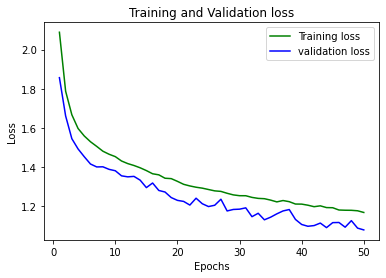

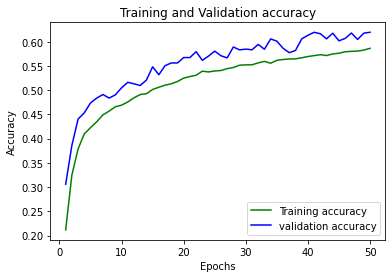

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Method three
IMPROVING THE MODEL WITH DATA AUGMENTATION
Image Augmentation is the process of artificially increasing the variations of the images in the datasets by flipping, enlarging, rotating the original images.
Augmentations also include shifting and changing the brightness of the images.

In [ ]:


import keras
import numpy as np
from tensorflow.keras import optimizers
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from keras.callbacks import LearningRateScheduler, TensorBoard
from keras.preprocessing.image import ImageDataGenerator

batch_size    = 128
epochs        = 50
iterations    = 391
num_classes   = 10
mean          = [125.307, 122.95, 113.865]
std           = [62.9932, 62.0887, 66.7048]

def build_model():
    model = Sequential()
    model.add(Conv2D(6, (5, 5), padding='valid', activation = 'relu', kernel_initializer='he_normal', input_shape=(32,32,3)))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(16, (5, 5), padding='valid', activation = 'relu', kernel_initializer='he_normal'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(120, activation = 'relu', kernel_initializer='he_normal'))
    model.add(Dense(84, activation = 'relu', kernel_initializer='he_normal'))
    model.add(Dense(10, activation = 'softmax', kernel_initializer='he_normal'))
    sgd = optimizers.SGD(lr=.1, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

def scheduler(epoch):
    if epoch < 100:
        return 0.01
    
    return 0.001


(x_train, y_train), (x_test, y_test) = load_data()


"""
n = 8 
X_train_sample = x_train[:n]

from keras.preprocessing.image import ImageDataGenerator

datagen_train = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip = True,
                             width_shift_range=0.125,
                             height_shift_range=0.125,
                             fill_mode='constant',
                             cval=0.,
                             rotation_range = 90,
                             width_shift_range = 0.1)


dataget_train.fit(X_train_sample)

from scipy.misc import toimage

fig = plt.figure(figsize = (20,2))
for x_batch in dataget_train.flow(X_train_sample, batch_size = n):
     for i in range(0,n):
            ax = fig.add_subplot(1, n, i+1)
            ax.imshow(toimage(x_batch[i]))
     fig.suptitle('Augmented images (rotated 90 degrees)')
     plt.show()
     break;
"""



y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')  


for i in range(3):
    x_train[:,:,:,i] = (x_train[:,:,:,i] - mean[i]) / std[i]
    x_test[:,:,:,i] = (x_test[:,:,:,i] - mean[i]) / std[i]
    

model = build_model()
print(model.summary())
# set callback
tb_cb = TensorBoard(log_dir='./lenet_dp_da', histogram_freq=0)
change_lr = LearningRateScheduler(scheduler)
cbks = [change_lr,tb_cb]


datagen = ImageDataGenerator(horizontal_flip=True,
                             vertical_flip = True,
                             width_shift_range=0.125,
                             height_shift_range=0.125,
                             fill_mode='constant',
                             cval=0.,
                             rotation_range = 90)

datagen.fit(x_train)

  
history = model.fit_generator(datagen.flow(x_train, y_train,batch_size=batch_size),
                    steps_per_epoch=iterations,
                    epochs=epochs,
                    callbacks=cbks,
                    validation_data=(x_test, y_test))

    
scores = model.evaluate(x_train, y_train, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 28, 28, 6)         456       
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 6)        0         
 2D)                                                             
                                                                 
 conv2d_5 (Conv2D)           (None, 10, 10, 16)        2416      
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 5, 5, 16)         0         
 2D)                                                             
                                                                 
 flatten_2 (Flatten)         (None, 400)               0         
                                                                 
 dense_6 (Dense)             (None, 120)              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


None
Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:108: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.


391/391 [==============================] - 46s 116ms/step - loss: 1.9910 - accuracy: 0.2659 - val_loss: 1.8250 - val_accuracy: 0.3411 - lr: 0.0100
Epoch 2/50
391/391 [==============================] - 40s 102ms/step - loss: 1.8362 - accuracy: 0.3254 - val_loss: 1.7597 - val_accuracy: 0.3654 - lr: 0.0100
Epoch 3/50
391/391 [==============================] - 39s 99ms/step - loss: 1.7723 - accuracy: 0.3498 - val_loss: 1.6792 - val_accuracy: 0.3918 - lr: 0.0100
Epoch 4/50
391/391 [==============================] - 39s 100ms/step - loss: 1.7352 - accuracy: 0.3692 - val_loss: 1.7411 - val_accuracy: 0.3720 - lr: 0.0100
Epoch 5/50
391/391 [==============================] - 39s 98ms/step - loss: 1.7030 - accuracy: 0.3803 - val_loss: 1.7830 - val_accuracy: 0.3764 - lr: 0.0100
Epoch 6/50
391/391 [==============================] - 39s 100ms/step - loss: 1.6816 - accuracy: 0.3906 - val_loss: 1.6298 - val_accuracy: 0.4189 - lr: 0.0100
Epoch 7/50
391/391 [==============================] - 40s 101ms/s

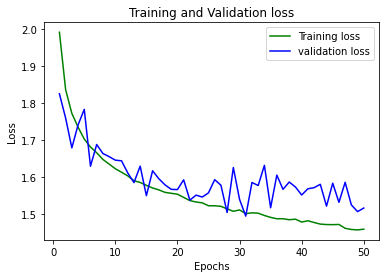

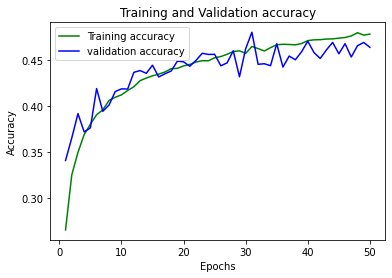

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Method four
Hyper perameter using keras tuner

In [ ]:
#from tensorflow import keras
import tensorflow as tf
import IPython
import keras
import numpy as np
from tensorflow.keras import optimizers
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D
from keras.callbacks import LearningRateScheduler, TensorBoard
from keras.preprocessing.image import ImageDataGenerator
!pip install keras-tuner
import kerastuner as kt

batch_size    = 128
epochs        = 50
iterations    = 391
num_classes   = 10
mean          = [125.307, 122.95, 113.865]
std           = [62.9932, 62.0887, 66.7048]


#( train_img, train_label ), ( test_img , test_label ) = load_data()
(x_train, y_train), (x_test, y_test) = load_data()

y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')  


for i in range(3):
    x_train[:,:,:,i] = (x_train[:,:,:,i] - mean[i]) / std[i]
    x_test[:,:,:,i] = (x_test[:,:,:,i] - mean[i]) / std[i]

"""
train_img = train_img.astype( 'float32' ) / 255
test_img = test_img.astype( 'float32' ) / 255
train_label = keras.utils.to_categorical( train_label , num_classes=10 ) 
test_label = keras.utils.to_categorical( test_label , num_classes=10 )


def model( hp ):
    model = keras.Sequential()
    hp_units = hp.Int( 'units', min_value=32, max_value=512, step=32)
    model.add( keras.layers.Conv2D( hp_units , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' , input_shape=( 32 , 32 , 3 ) ) )
    model.add( keras.layers.Conv2D( hp_units , kernel_size=( 3 , 3 ) , strides=1 , activation='relu' , input_shape=( 32 , 32 , 3 ) ) )
    model.add( keras.layers.Flatten() )
    tf.keras.activations.relu
    activation = hp.Choice( 'activation' , values=[ 'selu' , 'relu' , 'leaky_relu' ] )
    model.add( keras.layers.Activation( activation ) )
    model.add( keras.layers.Dense( 10 , activation='softmax' ) )
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
    model.compile(optimizer = keras.optimizers.Adam(learning_rate = hp_learning_rate),
                loss='categorical_crossentropy', 
                metrics = ['accuracy'])
    return model
"""


def build_model(hp):
    model = Sequential()
    hp_units = hp.Int( 'units', min_value=8, max_value=120, step=16)
    model.add(Conv2D(hp_units, (5, 5), padding='valid', activation = 'relu', kernel_initializer='he_normal', input_shape=(32,32,3)))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(hp_units, (5, 5), padding='valid', activation = 'relu', kernel_initializer='he_normal'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Flatten())
    activation = hp.Choice( 'activation' , values=[ 'selu' , 'relu' , 'leaky_relu' ] )
    model.add(Dense(120, activation = activation, kernel_initializer='he_normal'))
    model.add(Dense(84, activation = activation, kernel_initializer='he_normal'))
    model.add(Dense(10, activation = 'softmax', kernel_initializer='he_normal'))
    hp_learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]) 
    sgd = optimizers.SGD(lr=hp_learning_rate, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model

tuner = kt.tuners.Hyperband( build_model,
                     objective='val_accuracy', 
                     max_epochs=10,
                     factor=3,
                     directory='opt_dir',
                     project_name='cifar10CNNopt' )

tuner.search(x_train, y_train, epochs=15 , validation_data=(x_test, y_test))

# Optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

# Load the optimal parameters
model = tuner.hypermodel.build(best_hps)

# Train the model using them
model.fit(x_train, y_train, epochs = 50, validation_data = (x_test, y_test))


print(model.summary())

history = model.fit(x_train,
          y_train,
          batch_size=batch_size,
                    steps_per_epoch=iterations,
                    epochs=epochs,
                    validation_data=(x_test, y_test))
    
scores = model.evaluate(x_train, y_train, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Trial 27 Complete [00h 38m 22s]
val_accuracy: 0.703000009059906

Best val_accuracy So Far: 0.703000009059906
Total elapsed time: 04h 29m 02s

Search: Running Trial #28

Value             |Best Value So Far |Hyperparameter
120               |104               |units
leaky_relu        |leaky_relu        |activation
0.0001            |0.001             |learning_rate
10                |10                |tuner/epochs
0                 |0                 |tuner/initial_epoch
0                 |0                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/10
 317/1563 [=====>........................] - ETA: 3:33 - loss: 2.0817 - accuracy: 0.2640

In [ ]:

import keras
import numpy as np
from tensorflow.keras import optimizers
from keras.models import Sequential
from keras.layers import Conv2D, Dense, Flatten, MaxPooling2D, LeakyReLU
from keras.callbacks import LearningRateScheduler, TensorBoard
from keras.preprocessing.image import ImageDataGenerator

batch_size    = 128
epochs        = 50
iterations    = 391
num_classes   = 10
mean          = [125.307, 122.95, 113.865]
std           = [62.9932, 62.0887, 66.7048]

def build_model():
    model = Sequential()
    model.add(Conv2D(104, (5, 5), padding='valid', activation = 'relu', kernel_initializer='he_normal', input_shape=(32,32,3)))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Conv2D(104, (5, 5), padding='valid', activation = 'relu', kernel_initializer='he_normal'))
    model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    model.add(Flatten())
    model.add(Dense(120, kernel_initializer='he_normal'))
    model.add(LeakyReLU(alpha=0.3))
    model.add(Dense(84, kernel_initializer='he_normal'))
    model.add(LeakyReLU(alpha=0.3))
    model.add(Dense(10, activation = 'softmax', kernel_initializer='he_normal'))
    sgd = optimizers.SGD(lr=0.001, momentum=0.9, nesterov=True)
    model.compile(loss='categorical_crossentropy', optimizer=sgd, metrics=['accuracy'])
    return model



(x_train, y_train), (x_test, y_test) = load_data()
y_train = keras.utils.np_utils.to_categorical(y_train, num_classes)
y_test = keras.utils.np_utils.to_categorical(y_test, num_classes)
x_train = x_train.astype('float32')
x_test = x_test.astype('float32')  


for i in range(3):
    x_train[:,:,:,i] = (x_train[:,:,:,i] - mean[i]) / std[i]
    x_test[:,:,:,i] = (x_test[:,:,:,i] - mean[i]) / std[i]
    

model = build_model()
print(model.summary())

history = model.fit(x_train,
          y_train,
          batch_size=batch_size,
                    steps_per_epoch=iterations,
                    epochs=epochs,
                    validation_data=(x_test, y_test))
    
scores = model.evaluate(x_train, y_train, verbose=1)
print('Test loss:', scores[0])
print('Test accuracy:', scores[1])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 28, 28, 104)       7904      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 14, 14, 104)      0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 10, 10, 104)       270504    
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 5, 5, 104)        0         
 2D)                                                             
                                                                 
 flatten_1 (Flatten)         (None, 2600)              0         
                                                                 
 dense_1 (Dense)             (None, 120)              

/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


None
Epoch 1/50
391/391 [==============================] - 307s 783ms/step - loss: 1.6590 - accuracy: 0.4128 - val_loss: 1.4324 - val_accuracy: 0.4932
Epoch 2/50
391/391 [==============================] - 303s 774ms/step - loss: 1.3232 - accuracy: 0.5333 - val_loss: 1.2632 - val_accuracy: 0.5565
Epoch 3/50
391/391 [==============================] - 302s 773ms/step - loss: 1.1735 - accuracy: 0.5870 - val_loss: 1.1819 - val_accuracy: 0.5883
Epoch 4/50
391/391 [==============================] - 302s 772ms/step - loss: 1.0731 - accuracy: 0.6248 - val_loss: 1.1424 - val_accuracy: 0.6039
Epoch 5/50
391/391 [==============================] - 301s 770ms/step - loss: 0.9933 - accuracy: 0.6549 - val_loss: 1.0791 - val_accuracy: 0.6256
Epoch 6/50
391/391 [==============================] - 301s 769ms/step - loss: 0.9283 - accuracy: 0.6781 - val_loss: 1.0327 - val_accuracy: 0.6422
Epoch 7/50
391/391 [==============================] - 301s 769ms/step - loss: 0.8740 - accuracy: 0.6969 - val_loss: 0.9

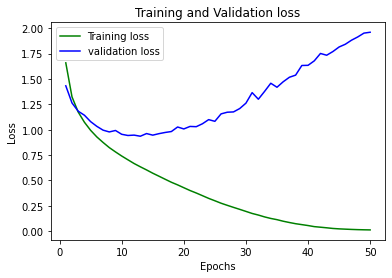

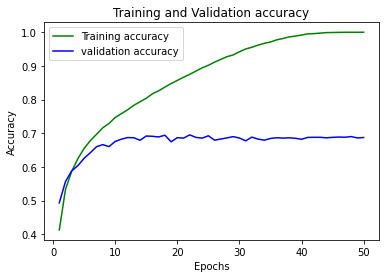

In [ ]:
loss_train = history.history['loss']
loss_val = history.history['val_loss']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training loss')
plt.plot(epochs, loss_val, 'b', label='validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

loss_train = history.history['accuracy']
loss_val = history.history['val_accuracy']
epochs = range(1,51)
plt.plot(epochs, loss_train, 'g', label='Training accuracy')
plt.plot(epochs, loss_val, 'b', label='validation accuracy')
plt.title('Training and Validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()